&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[Home Page](../START_HERE.ipynb)

&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;
[1]
[2](02-SGD.ipynb)
[3](03_CuML_Exercise.ipynb)
[4](04_CuML_Solution.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](02-SGD.ipynb)

# Introduction to cuML and how it relates to Scikit-learn

Scikit-Learn is an incredibly powerful toolkit that allows data scientists to quickly build models from their data, and it one of the most common and useful tools in the Python data science ecosystem. cuML is the RAPIDS library that implements similar machine learning algorithms that use CUDA to run on GPUs, with an API that mirrors the Scikit-learn one as much as possible. 

Below we will go through and example of how to create a Linear Regression model, and how easy it is to pick up from Scikit-learn based workflows. Afterwards we will explore some more advanced functionality, like hyperparameter optimization and ecosystem interoperability that showcase the usefulness of cuML in different contexts. The tutorial contains modules with embedded exercises to help understanding the concepts.

For more information about CuML, refer to the documentation here: https://docs.rapids.ai/api/cuml/stable/api.html#regression-and-classification

## Here is the list of exercises and modules in the lab:
- <a href='#lr'>Linear Regression</a><br> This module covers the Scikit-learn implementation of the Linear Regression algorithm and the corresponding CuML version.
- <a href='#rr'>Ridge Regression and Hyperparameters</a><br> This module covers the Scikit-learn implementation of the Ridge Regression algorithm and the corresponding CuML version. We will also learn how to perform hyperparameter optimization to boost the accuracy of our model.


<a id='lr'></a>

## 1. Simple Linear Regression
The basic Linear Regression is a simple machine learning model where the relationship between a variable `y`, which we will call the response, and a set of variables `X`, which we will call the predictors, is explained by trying to model `y` as a linear combination of variables in `X`.

Lets start by creating a sample dataset: 

In [1]:
# Using numpy for data genera

import matplotlib.pyplot as plt
import numpy as np; print('NumPy Version:', np.__version__)
%matplotlib inline
import sys

NumPy Version: 1.19.2


In [2]:
# create the relationship: y = 2.0 * x + 1.0
n_rows = 10000
w = 2.0
x = np.random.normal(loc=0, scale=1, size=(n_rows,))
b = 1.0
y = w * x + b

# add a bit of random noise
noise = np.random.normal(loc=0, scale=2, size=(n_rows,))
y_noisy = y + noise

We can now visualize our data using `matplotlib`:

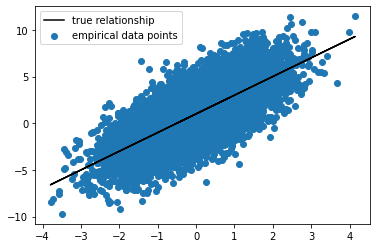

In [3]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.legend()

The `LinearRegression` class implemented in both cuML and Scikit-Learn are based on ordinary least squares (OLS), which essentially minimizes the square distance between the observarions (blue dots) and the relantionship (black line) estimated by the class. 

This means that this is actually an optimization process, so cuML offers 3 algorithms for this: Singular Value Decomposition `SVD`, Eigendecomposition `Eig` and Coordinate Descente `CD` to fit the linear model. The  `SVD` is more stable, `Eig` (which is the default) is typically much faster and `CD`  can be faster when the data is large enough.


<a id='scik'></a>

### Scikit-Learn

We'll begin with the `LinearRegression` class from Scikit-Learn to instantiate a model and fit it to our data:

In [4]:
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.linear_model import LinearRegression

Scikit-Learn Version: 0.23.1


In [5]:
linear_regression = LinearRegression()

Now that we have a trained class with an estimated model, we can predict new observations. Typically, for regression models, the Scikit-learn API offers two fundamental methods:

1. `fit`: Fit the model with X and y. This method performs the training of the model. 
2. `predict`: Predicts the y for X.

In [6]:
linear_regression.fit(np.expand_dims(x, 1), y_noisy)

LinearRegression()

To visualize how the model looks like, lets use NumPy to create a uniform number of points: 

In [7]:
# create new data and perform inference
inputs = np.linspace(start=-5, stop=5, num=1000000)

Now we can use our `predict` function: 

In [8]:
outputs = linear_regression.predict(np.expand_dims(inputs, 1))

Let's now visualize our empirical data points, the true relationship of the data, and the relationship estimated by the model. Looks pretty close!

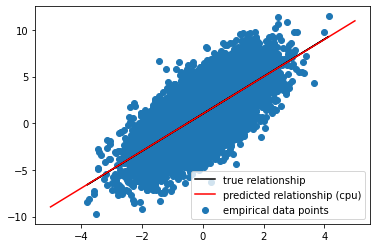

In [9]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.legend()

<a id='cuml'></a>

### cuML

The mathematical operations underlying many machine learning algorithms are often matrix multiplications, just like the ordinary least squares approach that was described above. These types of operations are highly parallelizable and can be greatly accelerated using a GPU. 

The objective of cuML is to make it easy to build machine learning models in an accelerated fashion using an interface nearly identical to Scikit-Learn. Now we'll explore how this looks in practice.



In [10]:
import cudf; print('cuDF Version:', cudf.__version__)

cuDF Version: 0.16.0a+1979.g2cda39b341


<a id='ex1'></a>

### Mini Exercise: create a cuDF Dataframe with `x` and `y`

Use the following cell to create a dataframe called `df`.


<details><summary><b>Solution</b></summary>
   <pre>
df = cudf.DataFrame({'x': x, 'y': y_noisy})
print(df.head())

</pre>
</details>

In [11]:
# create the dataframe here


Next, we'll load the GPU accelerated `LinearRegression` class from cuML, instantiate it, and fit it to our data.

In [12]:
import cuml; print('cuML Version:', cuml.__version__)
from cuml.linear_model import LinearRegression as LinearRegressionGPU

cuML Version: 0.16.0a+882.g5851f4140


The Linear Regression function accepts the following parameters:
1. algorithm:`eig`, `cd` or `svd` (default = `eig`).  Eig uses a eigendecomposition of the covariance matrix, and is much faster. SVD is slower, but is guaranteed to be stable.
2. fit_intercept:boolean (default = True).  If True, LinearRegression tries to correct for the global mean of y. If False, the model expects that you have centered the data.
3. normalize:boolean (default = False).  If True, the predictors in X will be normalized by dividing by it’s L2 norm. If False, no scaling will be done.

We will use the different columns of our dataframe to train our model 

<details><summary><b>Solution</b></summary>
   <pre>
linear_regression_gpu.fit(cp.expand_dims(cp.array(df['x']),1), y_noisy)

</pre>
</details>

In [15]:
# instantiate and fit model, change the column names if you used a different name
linear_regression_gpu = LinearRegressionGPU()
# this is equivalent to 
# linear_regression_gpu = LinearRegressionGPU(algorithm='eig', fit_intercept=True, normalize=False)

# Now lets fit X to y, replace column names if you named them differently


We can use this model to predict values for new data points, a step often called "inference" or "scoring". All model fitting and predicting steps are GPU accelerated.

<a id='ex2'></a>

### Mini Exercise: Use np.linspace to create a set of points adequate to visualize our model like we did with Scikit-learn

<details><summary><b>Solution</b></summary>
   <pre>

inputs = np.linspace(start=-5, stop=5, num=1000000)
new_data_df = cudf.DataFrame({'inputs': inputs})
gpu_outputs = linear_regression_gpu.predict(new_data_df[['inputs']])

</pre>
</details>

In [48]:
# create new data and perform inference. inputs is the same data from the scikit-learn example above 
# transformed to a cuDF Dataframe



Lastly, we can overlay our predicted relationship using our GPU accelerated Linear Regression model (green line) over our empirical data points (light blue circles), the true relationship (blue line), and the predicted relationship from a model built on the CPU (red line). We see that our GPU accelerated model's estimate of the true relationship (green line) is identical to the CPU based model's estimate of the true relationship (red line)!

<details><summary><b>Solution</b></summary>
   <pre>

plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.plot(inputs, gpu_outputs.to_array(), color='green', label='predicted relationship (gpu)')
plt.legend()

</pre>
</details>

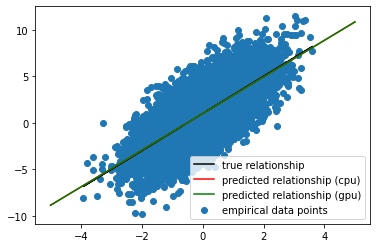

In [51]:
# Adapt the code for the graph we used before to graph the new model




Its nice to see that the red and green lines are identical, showing cuML and Scikit-learn ended up with identical models. 

<a id='rr'></a>

## 2. Ridge Regression and Hyperparameters

Ridge extends the `LinearRegression` (in both Scikit-learn and cuML) by providing L2 regularization on the coefficients when predicting response y with a linear combination of the predictors in X. Essentially it can reduce the variance of the predictors, and improves the conditioning of the problem, which can improve the performance of the models when data is not suitable for a simple ordinary least squares linear regression.

For this section we will use a built in dataset of Scikit-learn: the diabetes dataset. 

In [21]:
from sklearn import datasets
diabetes = datasets.load_diabetes()

Description of the Diabetes dataset

```
Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of `n=442` diabetes patients, as well as the response of interest, aquantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**  :
- Number of Instances: 442  
- Number of Attributes: First 10 columns are numeric predictive values  
- Target: Column 11 is a quantitative measure of disease progression one year after baseline  
- Attribute Information: Age, Sex, Body mass index, Average blood pressure, S1, S2, S3, S4, S5, S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).Source 
- URL:https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499.(https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)'
```

A common practice is to train models on part of the data and use the rest for testing the performance of the model, so lets divide our dataset:

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.2)

Now lets import our Ridge Regression classes from cuML and Scikit-learn:

In [23]:
from cuml import Ridge as cuRidge
from sklearn.linear_model import Ridge as skRidge

The Ridge Regression classes of both cuML and Scikit-learn have quite a few parameters that can be set. For this exercise the relevant cuML ones are: 

```
    alpha : float or double
        Regularization strength - must be a positive float. Larger values
        specify stronger regularization. Array input will be supported later.
    solver : 'eig' or 'svd' or 'cd' (default = 'eig')
        Eig uses a eigendecomposition of the covariance matrix, and is much
        faster.
        SVD is slower, but guaranteed to be stable.
        CD or Coordinate Descent is very fast and is suitable for large
        problems.
    fit_intercept : boolean (default = True)
        If True, Ridge tries to correct for the global mean of y.
        If False, the model expects that you have centered the data.
    normalize : boolean (default = False)
        If True, the predictors in X will be normalized by dividing by it's L2
        norm.
        If False, no scaling will be done.
```

Most of the parameters are the same for Scikit-learn, except for solver, where the options are: 

```
    solver : ‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’
        
```
        
It is important to see that even though both libraries are performing a Ridge Regression, underneath there are different solvers being used (except for `svd`). This can lead to slightly different results (and final performance) where both results are technically correct even though they differ. 

For the exercise feel free to use `solver=auto` for Scikit-learn, otherwise we recommend using `cholesky`.

<a id='exx1'></a>

### Exercise: Create the Ridge Regression objects for both cuML and Scikit-learn with matching parameters and fit `X_train` and `y_train`

<details><summary><b>Solution for Scikit-learn</b></summary>
   <pre>

alpha = np.array([1.0])
fit_intercept = True
normalize = False

ridge = skRidge(alpha=alpha, fit_intercept=fit_intercept, normalize=normalize, solver='cholesky')
ridge.fit(X_train, y_train)


</pre>
</details>

<details><summary><b>Solution for cuML</b></summary>
   <pre>

alpha = np.array([1.0])
fit_intercept = True
normalize = False

cu_ridge = cuRidge(alpha=alpha, fit_intercept=fit_intercept, normalize=normalize, solver='eig')
cu_ridge.fit(X_train, y_train)

</pre>
</details>

<a id='exx2'></a>

### Exercise: Predict the values for `X_test` and evaluate its performance

*Hint: The Ridge classes have a `score` method to evaluate performance*

*Note: cuML as of version 0.8 has a limitation to only being able to accept cuDF objects for `score`, so we've provided a helpful conversion*

In [ ]:
from numba import cuda
record_data = {'fea%d'%i: X_test[:,i] for i in range(X_test.shape[1])}
test_df = cudf.DataFrame(record_data)

y_df = cudf.Series(y_test)

<details><summary><b>Solution for Scikit-learn</b></summary>
   <pre>

print('Scikit-learn accuracy: ' + str(ridge.score(X_test, y_test)))
</pre>
</details>

<details><summary><b>Solution for cuML</b></summary>
   <pre>

print('cuML accuracy: ' + str(cu_ridge.score(test_df, y_df)))

</pre>
</details>


### Improving the accuracy of our models

One of the most useful components beyond basic models that Scikit-learn offers is hyperparameter optimization for its models. Hyperparameter optimization means looking for the values of parameters that maximize how well our model can predict observations in `X_test`. 

Fortunately cuML is compatible with Scikit-learn hyperparameter optimization!!! Note: It also is compatible with other libraries, such as dask-ml that perform hyperparameter optimization with more advanced strategies/levels of parallelization.

For this lets use the `GridSearchCV` class of Scikit-learn, which like the name suggest performs a search in a grid of values of the parameters that we specify:

In [ ]:
# lets import the class
from sklearn.model_selection import GridSearchCV

# Here we tell GridSearchCV what values of parameters to explore
params = {'alpha': np.logspace(-3, -1, 10)}

In [ ]:
grid = GridSearchCV(ridge, params, scoring='r2')
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_, grid.best_score_

Here are the parameter we are going to optimise:
- Alpha - Regularization strength; must be a positive float. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization. Alpha corresponds to 1 / (2C) in other linear models such as LogisticRegression or sklearn.svm.LinearSVC. If an array is passed, penalties are assumed to be specific to the targets. Hence they must correspond in number.
- fit_interceptbool, default=True
Whether to fit the intercept for this model. If set to false, no intercept will be used in calculations (i.e. X and y are expected to be centered).
- normalizebool, default=False
This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm. If you wish to standardize, please use sklearn.preprocessing.StandardScaler before calling fit on an estimator with normalize=False.
- solver{‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’}, default=’auto’
Solver to use in the computational routines:
‘auto’ chooses the solver automatically based on the type of data. 
‘svd’ uses a Singular Value Decomposition of X to compute the Ridge coefficients. More stable for singular matrices than ‘cholesky’. ‘cholesky’ uses the standard scipy.linalg.solve function to obtain a closed-form solution. ‘sparse_cg’ uses the conjugate gradient solver as found in scipy.sparse.linalg.cg. As an iterative algorithm, this solver is more appropriate than ‘cholesky’ for large-scale data (possibility to set tol and max_iter). ‘lsqr’ uses the dedicated regularized least-squares routine scipy.sparse.linalg.lsqr. It is the fastest and uses an iterative procedure. ‘sag’ uses a Stochastic Average Gradient descent, and ‘saga’ uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

In [ ]:
ridge = skRidge(alpha=grid.best_params_['alpha'], 
                fit_intercept=fit_intercept, 
                normalize=normalize, 
                solver='cholesky')
ridge.fit(X_train, y_train)

<a id='exx3'></a>

### Exercise: Perform a hyperparameter optimization for the cuML Ridge Regression

*Hint: You do not need to import any other `GridSearchCV` objects, you can use the Scikit-learn one with cuML models!*

<details><summary><b>Solution</b></summary>
   <pre>

cu_grid = GridSearchCV(cu_ridge, params, scoring='r2')
cu_grid.fit(X_train, y_train)
cu_grid.best_params_, cu_grid.best_score_

</pre>
</details>

# Conclusion

We have learnt how to create machine learning models in CuML, from feeding data to them and fitting the models to testing their performance on data. We have also understood how to perform hyperparameter optimization to boost the model accuracy. As we have based this tutorial only on CuDF objects, you may visit the bonus lab [here](Bonus_Lab-LogisticRegression.ipynb) to learn the implementation of Logistic Regression algorithm using CuPy objects. Moving on to the next lab, we will be learning a more complex machine learning model - namely the Mini Batch SGD (MBSGD) model.

## Licensing
  
This material is released by NVIDIA Corporation under the Creative Commons Attribution 4.0 International (CC BY 4.0).

&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&ensp;
[1]
[2](02-SGD.ipynb)
[3](03_CuML_Exercise.ipynb)
[4](04_CuML_Solution.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](02-SGD.ipynb)


&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;
[Home Page](../START_HERE.ipynb)